In [1]:
pip install equinox optax diffrax

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.2/175.2 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.6/163.6 kB 18.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.7/40.7 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.5/66.5 kB 805.4 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.5/81.5 kB 8.0 MB/s eta 0:00:00


# Train RNN

This is an introductory example. We demonstrate what using Equinox normally looks like day-to-day.

Here, we'll train an RNN to classify clockwise vs anticlockwise spirals.

This example is available as a Jupyter notebook [here](https://github.com/patrick-kidger/equinox/blob/main/examples/train_rnn.ipynb).

In [11]:
import math
import time
import diffrax
import equinox as eqx
import jax
import jax.lax as lax
import jax.nn as jnn
import jax.numpy as jnp
import jax.random as jrandom
import numpy as np
import optax  # https://github.com/deepmind/optax

We begin by importing the usual libraries, setting up a very simple dataloader, and generating a toy dataset of spirals.

In [3]:
def dataloader(arrays, batch_size, *, key):
    dataset_size = arrays[0].shape[0]
    assert all(array.shape[0] == dataset_size for array in arrays)
    indices = jnp.arange(dataset_size)
    while True:
        perm = jrandom.permutation(key, indices)
        (key,) = jrandom.split(key, 1)
        start = 0
        end = batch_size
        while end < dataset_size:
            batch_perm = perm[start:end]
            yield tuple(array[batch_perm] for array in arrays)
            start = end
            end = start + batch_size

In [35]:
def _get_data(ts, *, key):
    y0 = jrandom.uniform(key, (2,), minval = jnp.array([0,0.5]), maxval = 2)
    r=2.5
    K=2.
    n=0.8
    omega=0.5
    miu=0.4
    nu=1.5
    def f(t, y, args):
        # El tamaño de y es (L,2)
        T = y[0]
        E = y[1]
        x0 = r*T*(1-(T/K))-(n*T*E)
        x1 = omega+miu*T*E-nu*E
        return jnp.stack([x0, x1], axis=-1)

    solver = diffrax.Tsit5()
    dt0 = 0.01
    saveat = diffrax.SaveAt(ts=ts)
    sol = diffrax.diffeqsolve(
        diffrax.ODETerm(f), solver, ts[0], ts[-1], dt0, y0, saveat=saveat
    )
    ys = sol.ys
    return ys


def get_data(dataset_size, *, key):

    ts = jnp.linspace(0, 10, 100)
    key = jrandom.split(key, dataset_size)
    ys = jax.vmap(lambda key: _get_data(ts, key=key))(key)

    return ys, ts

Now for our model.

Purely by way of example, we handle the final adding on of bias ourselves, rather than letting the `linear` layer do it. This is just so we can demonstrate how to use custom parameters in models.

In [24]:
class RNN(eqx.Module):
    hidden_size: int
    cell: eqx.Module
    linear: eqx.nn.Linear
    bias: jax.Array
    sequence_length: int

    def __init__(self, in_size, out_size, hidden_size, *, key, sequence_length=100):
        ckey, lkey = jrandom.split(key)
        self.hidden_size = hidden_size
        self.cell = eqx.nn.GRUCell(in_size, hidden_size, key=ckey)
        self.linear = eqx.nn.Linear(hidden_size, out_size, use_bias=False, key=lkey)
        self.bias = jnp.zeros(out_size)
        self.sequence_length = sequence_length

    def __call__(self, input):
        hidden = jnp.zeros((self.hidden_size,))

        def f(carry, _):
            hidden, input = carry
            hidden = self.cell(input, hidden)
            output = self.linear(hidden) + self.bias
            return (hidden, output), output # carry, thing-to-stack

        init_state = (hidden, input)
        (_, _), outs = lax.scan(f, init_state, None, length=self.sequence_length)
        return jnp.stack(outs)

And finally the training loop.

In [25]:
import matplotlib.pyplot as plt
def main(
    dataset_size=256,
    batch_size=32,
    learning_rate=3e-3,
    steps=1000,
    hidden_size=16,
    depth=1,
    seed=5678,
    print_every=100,
    plot= True,
):
    loader_key, data_key, model_key = jrandom.split(jrandom.PRNGKey(seed), 3)
    xs, ys = get_data(dataset_size, key=data_key)
    iter_data = dataloader((xs,), batch_size, key = loader_key)

    model = RNN(in_size=2, out_size=2, hidden_size=hidden_size, key=model_key)

    @eqx.filter_value_and_grad
    def compute_loss(model, x, y):
        pred_y = jax.vmap(model)(x[:,0,:])
        return jnp.mean((x - pred_y) ** 2)

    # Important for efficiency whenever you use JAX: wrap everything into a single JIT
    # region.
    @eqx.filter_jit
    def make_step(model, x, y, opt_state):
        loss, grads = compute_loss(model, x, y)
        updates, opt_state = optim.update(grads, opt_state)
        model = eqx.apply_updates(model, updates)
        return loss, model, opt_state

    optim = optax.adam(learning_rate)
    opt_state = optim.init(model)
    for step, (x,) in zip(range(steps), iter_data):
        start = time.time()
        loss, model, opt_state = make_step(model, x, ys, opt_state)
        loss = loss.item()
        end = time.time()
        if (step % print_every) == 0 or step == steps - 1:
            print(f"Step: {step}, Loss: {loss}, Computation time: {end - start}")

    if plot:

      index = 1

      new_seed = 567

      new_key = jrandom.PRNGKey(new_seed)

      ys_prueba, ts_prueba = get_data(dataset_size, key=new_key)

      model_y = model( ys_prueba[index, 0])

      fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10,6))
      fig.tight_layout(rect=[0, 0, 1, 0.95], pad=3.0)  # Ajustar diseño de la figura


      # Subgráfico 1
      ax1.plot(ts_prueba, ys_prueba[index, :, 0], c="dodgerblue", label="Real")
      ax1.plot(ts_prueba, model_y[:, 0], c="dodgerblue", label="Model", linestyle="dashed")
      ax1.set_xlabel('t')
      ax1.set_ylabel('T')
      ax1.legend()  # Añadir leyenda al subgráfico 1
      ax1.grid(True)  # Añadir rejilla al subgráfico 1

      # Subgráfico 2
      ax2.plot(ts_prueba, ys_prueba[index, :, 1], c="crimson", label="Real")
      ax2.plot(ts_prueba, model_y[:, 1], c="crimson", label="Model", linestyle="dashed")
      ax2.set_xlabel('t')
      ax2.set_ylabel('E')
      ax2.legend()  # Añadir leyenda al subgráfico 2
      ax2.grid(True)  # Añadir rejilla al subgráfico 2

      # Subgráfico 3
      ax3.plot(ys_prueba[index, :, 0], ys_prueba[index, :, 1], c="blue", label="Real")
      ax3.plot(model_y[:, 0], model_y[:, 1], c="red", label="Model", linestyle="dashed")
      ax3.set_xlabel('T')
      ax3.set_ylabel('E')
      ax3.legend()  # Añadir leyenda al subgráfico 3
      ax3.grid(True)  # Añadir rejilla al subgráfico 3

      # Mostrar la figura
      plt.show()

      errorT=((model_y[:, 0]-ys_prueba[0, :, 0])**2).mean()
      errorE=((model_y[:, 1]-ys_prueba[0, :, 1])**2).mean()
    return xs, ys, model

`eqx.filter_value_and_grad` will calculate the gradient with respect to all floating-point arrays in the first argument (`model`). In this case the `model` parameters will be differentiated, whilst `model.hidden_size` is an integer and will get `None` as its gradient.

Likewise, `eqx.filter_jit` will look at all the arguments passed to `make_step`, and automatically JIT-trace every array and JIT-static everything else. In this case the `model` parameters and the data `x` and `y` will be traced, whilst `model.hidden_size` is an integer and will be static'd instead.

Step: 0, Loss: 1.3938767910003662, Computation time: 0.9279360771179199
Step: 100, Loss: 0.03091590665280819, Computation time: 0.004438638687133789
Step: 200, Loss: 0.023169655352830887, Computation time: 0.004427194595336914
Step: 300, Loss: 0.016395268961787224, Computation time: 0.004312992095947266
Step: 400, Loss: 0.011545436456799507, Computation time: 0.004236459732055664
Step: 500, Loss: 0.007204894442111254, Computation time: 0.0043408870697021484
Step: 600, Loss: 0.009256375022232533, Computation time: 0.004320383071899414
Step: 700, Loss: 0.004757617134600878, Computation time: 0.004118680953979492
Step: 800, Loss: 0.006302302237600088, Computation time: 0.0041961669921875
Step: 900, Loss: 0.004865346010774374, Computation time: 0.007291316986083984
Step: 999, Loss: 0.002243194729089737, Computation time: 0.007093667984008789


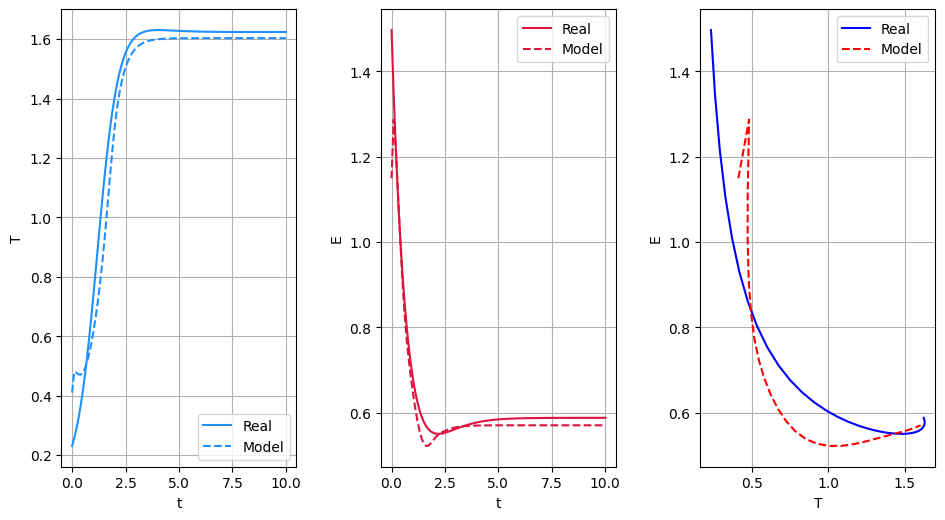

In [36]:
ys, ts, model = main()

In [8]:
class Func(eqx.Module):
    mlp: eqx.nn.MLP

    def __init__(self, data_size, width_size, depth, *, key, **kwargs):
        super().__init__(**kwargs)
        self.mlp = eqx.nn.MLP(
            in_size=data_size,
            out_size=data_size,
            width_size=width_size,
            depth=depth,
            activation=jnn.softplus,
            key=key,
        )

    def __call__(self, t, y, args):
        return self.mlp(y)

class NeuralODE(eqx.Module):
    func: Func

    def __init__(self, data_size, width_size, depth, *, key, **kwargs):
        super().__init__(**kwargs)
        self.func = Func(data_size, width_size, depth, key=key)

    def __call__(self, ts, y0):
        #print(f"y0: {y0}")
        solution = diffrax.diffeqsolve(
            diffrax.ODETerm(self.func),
            diffrax.Tsit5(),
            t0=ts[0],
            t1=ts[-1],
            dt0=ts[1] - ts[0],
            y0=y0,
            stepsize_controller=diffrax.PIDController(rtol=1e-3, atol=1e-6),
            saveat=diffrax.SaveAt(ts=ts),
        )
        return solution.ys

In [14]:
def main2(
    dataset_size=256,
    batch_size=32,
    lr_strategy=(3e-3, 3e-3),
    steps_strategy=(1000, 1000),
    length_strategy=(0.1, 1),
    width_size=16,
    depth=4,
    seed=2,
    plot=True,
    print_every=100,
):
    key = jrandom.PRNGKey(seed)
    data_key, model_key, loader_key = jrandom.split(key, 3)

    ys, ts = get_data(dataset_size, key=data_key)
    _, length_size, data_size = ys.shape

    model = NeuralODE(data_size, width_size, depth, key=model_key)


    @eqx.filter_value_and_grad
    def grad_loss(model, ti, yi):
        #print(f"yi: {yi}")
        # yi es de tamaño: [32,10,2]
        # yi[:, 0] es en verdad la condición inicial de tamaño [32, 2]
        y_pred = jax.vmap(model, in_axes=(None, 0))(ti, yi[:, 0, :])
        return jnp.mean((yi - y_pred) ** 2)

    # Es la clausura de la optimización
    # (i.e. lo que ocurre en cada paso)
    @eqx.filter_jit
    def make_step(ti, yi, model, opt_state):
        loss, grads = grad_loss(model, ti, yi)
        updates, opt_state = optim.update(grads, opt_state)
        model = eqx.apply_updates(model, updates)
        return loss, model, opt_state

    # Training loop like normal.
    #
    # Only thing to notice is that up until step 500 we train on only the first 10% of
    # each time series. This is a standard trick to avoid getting caught in a local
    # minimum.

    # Entrenar NeuralODEs es pesado. Es difícil.

    # lr_strategy: (3e-3, 3e-3)
    # steps_strategy: (500, 500)
    # length_strategy: (0.1, 1)

    # Este for loop es en verdad dos fases de entrenamiento:
    # En la primera fase, se entrena por 500 pasos en el 10% del conjunto de datos
    # En la segunda fase, se entrena por 500 pasos en todos los datos.
    for lr, steps, length in zip(lr_strategy, steps_strategy, length_strategy):
        optim = optax.adabelief(lr)
        opt_state = optim.init(eqx.filter(model, eqx.is_inexact_array))
        _ts = ts[: int(length_size * length)]
        _ys = ys[:, : int(length_size * length)]
        for step, (yi,) in zip(
            range(steps), dataloader((_ys,), batch_size, key=loader_key)
        ):
            start = time.time()
            loss, model, opt_state = make_step(_ts, yi, model, opt_state)
            end = time.time()
            if (step % print_every) == 0 or step == steps - 1:
                print(f"Step: {step}, Loss: {loss}, Computation time: {end - start}")

    if plot:

      index = 3

      new_seed = 567

      new_key = jrandom.PRNGKey(new_seed)

      ys_prueba, ts_prueba = get_data(dataset_size, key=new_key)

      model_y = model(ts_prueba, ys_prueba[index, 0])

      fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10,6))
      fig.tight_layout(rect=[0, 0, 1, 0.95], pad=3.0)  # Ajustar diseño de la figura


      # Subgráfico 1
      ax1.plot(ts_prueba, ys_prueba[index, :, 0], c="dodgerblue", label="Real")
      ax1.plot(ts_prueba, model_y[:, 0], c="dodgerblue", label="Model", linestyle="dashed")
      ax1.set_xlabel('t')
      ax1.set_ylabel('T')
      ax1.legend()  # Añadir leyenda al subgráfico 1
      ax1.grid(True)  # Añadir rejilla al subgráfico 1

      # Subgráfico 2
      ax2.plot(ts_prueba, ys_prueba[index, :, 1], c="crimson", label="Real")
      ax2.plot(ts_prueba, model_y[:, 1], c="crimson", label="Model", linestyle="dashed")
      ax2.set_xlabel('t')
      ax2.set_ylabel('E')
      ax2.legend()  # Añadir leyenda al subgráfico 2
      ax2.grid(True)  # Añadir rejilla al subgráfico 2

      # Subgráfico 3
      ax3.plot(ys_prueba[index, :, 0], ys_prueba[index, :, 1], c="blue", label="Real")
      ax3.plot(model_y[:, 0], model_y[:, 1], c="red", label="Model", linestyle="dashed")
      ax3.set_xlabel('T')
      ax3.set_ylabel('E')
      ax3.legend()  # Añadir leyenda al subgráfico 3
      ax3.grid(True)  # Añadir rejilla al subgráfico 3

      # Mostrar la figura
      plt.show()

      errorT=((model_y[:, 0]-ys_prueba[0, :, 0])**2).mean()
      errorE=((model_y[:, 1]-ys_prueba[0, :, 1])**2).mean()
      return ts, ys, model
    else:
      new_size = int(dataset_size*0.1)
      new_seed = 567
      new_key = jrandom.PRNGKey(new_seed)
      ys_prueba, ts_prueba = get_data(new_size, key=new_key)
      model_y = jnp.zeros_like(ys_prueba)
      for i in range(ys_prueba.shape[0]):
        initial_value = ys_prueba[i, 0, :]
        model_y = model_y.at[i].set(model(ts_prueba, initial_value))
      diff_T = ys_prueba[:, :, 0] - model_y[:, :, 0]
      squared_diff_T = diff_T ** 2
      mse_T = jnp.mean(squared_diff_T)
      diff_E = ys_prueba[:, :, 1] - model_y[:, :, 1]
      squared_diff_E = diff_E ** 2
      mse_E = jnp.mean(squared_diff_E)
      error = jnp.mean(jnp.array([mse_E, mse_T]))
      print("El error cuadrático medio (MSE) es: para T", mse_T, ', para E',mse_E,'y general',error, 'depth:', depth, 'width_size:', width_size , 'seed:', seed)
      return ts, ys, model, error, depth, width_size

Step: 0, Loss: 0.07762353122234344, Computation time: 6.198560476303101
Step: 100, Loss: 0.026731446385383606, Computation time: 0.0052874088287353516
Step: 200, Loss: 0.004732471890747547, Computation time: 0.005296468734741211
Step: 300, Loss: 0.003009241772815585, Computation time: 0.00921630859375
Step: 400, Loss: 0.0004685810417868197, Computation time: 0.011014223098754883
Step: 500, Loss: 0.00020026690617669374, Computation time: 0.010391473770141602
Step: 600, Loss: 0.00014071204350329936, Computation time: 0.0069277286529541016
Step: 700, Loss: 0.00010093935998156667, Computation time: 0.005949258804321289
Step: 800, Loss: 6.735519855283201e-05, Computation time: 0.005980730056762695
Step: 900, Loss: 0.00013562080857809633, Computation time: 0.006556034088134766
Step: 999, Loss: 0.00012097780563635752, Computation time: 0.010650634765625
Step: 0, Loss: 0.0002873292251024395, Computation time: 6.212273597717285
Step: 100, Loss: 0.0032700938172638416, Computation time: 0.0175302

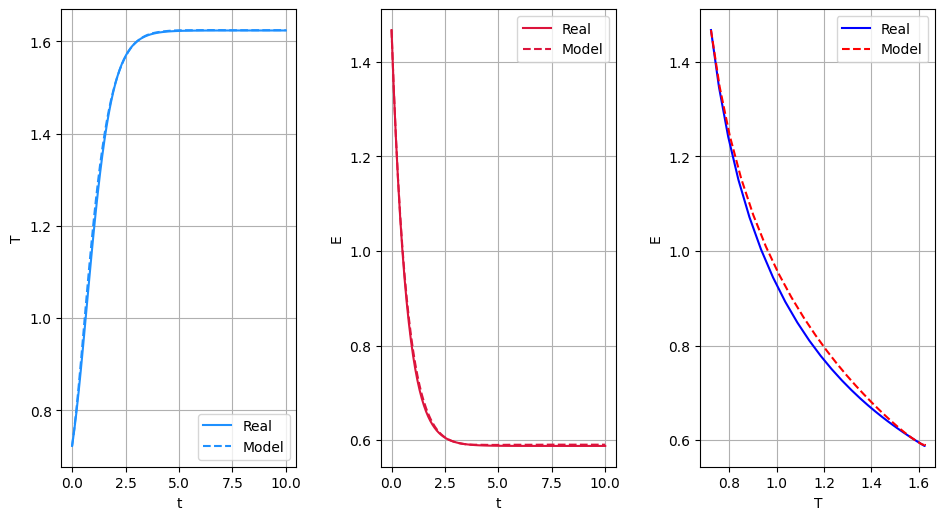

In [37]:
tsn, ysn, modeln = main2()

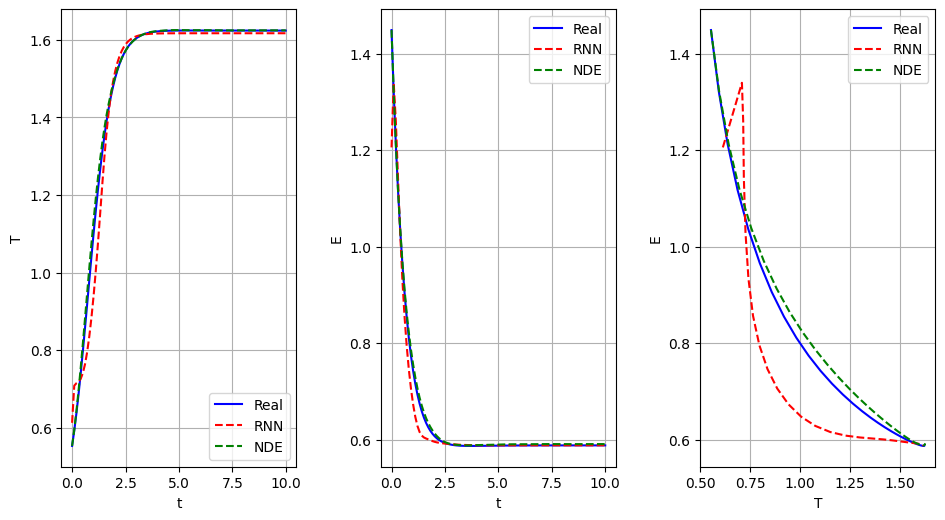

In [38]:
index = 12
new_size = int(256*0.1)
new_seed = 567
new_key = jrandom.PRNGKey(new_seed)

ys_prueba, ts_prueba = get_data(new_size, key=new_key)

model_y = model(ys_prueba[index, 0])
model_yn = modeln(ts_prueba, ys_prueba[index, 0])

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10,6))
fig.tight_layout(rect=[0, 0, 1, 0.95], pad=3.0)  # Ajustar diseño de la figura


# Subgráfico 1
ax1.plot(ts_prueba, ys_prueba[index, :, 0], c="blue", label="Real")
ax1.plot(ts_prueba, model_y[:, 0], c="red", label="RNN", linestyle="dashed")
ax1.plot(ts_prueba, model_yn[:, 0], c="green", label="NDE", linestyle="dashed")
ax1.set_xlabel('t')
ax1.set_ylabel('T')
ax1.legend()  # Añadir leyenda al subgráfico 1
ax1.grid(True)  # Añadir rejilla al subgráfico 1

# Subgráfico 2
ax2.plot(ts_prueba, ys_prueba[index, :, 1], c="blue", label="Real")
ax2.plot(ts_prueba, model_y[:, 1], c="red", label="RNN", linestyle="dashed")
ax2.plot(ts_prueba, model_yn[:, 1], c="green", label="NDE", linestyle="dashed")
ax2.set_xlabel('t')
ax2.set_ylabel('E')
ax2.legend()  # Añadir leyenda al subgráfico 2
ax2.grid(True)  # Añadir rejilla al subgráfico 2

# Subgráfico 3
ax3.plot(ys_prueba[index, :, 0], ys_prueba[index, :, 1], c="blue", label="Real")
ax3.plot(model_y[:, 0], model_y[:, 1], c="red", label="RNN", linestyle="dashed")
ax3.plot(model_yn[:, 0], model_yn[:, 1], c="green", label="NDE", linestyle="dashed")
ax3.set_xlabel('T')
ax3.set_ylabel('E')
ax3.legend()  # Añadir leyenda al subgráfico 3
ax3.grid(True)  # Añadir rejilla al subgráfico 3

# Mostrar la figura
plt.show()

errorT=((model_y[:, 0]-ys_prueba[0, :, 0])**2).mean()
errorE=((model_y[:, 1]-ys_prueba[0, :, 1])**2).mean()

In [31]:
new_size = 200
new_seed = 567
new_key = jrandom.PRNGKey(new_seed)
ys_prueba, ts_prueba = get_data(new_size, key=new_key)
model_y = jnp.zeros_like(ys_prueba)
model_yn = jnp.zeros_like(ys_prueba)
for i in range(ys_prueba.shape[0]):
  initial_value = ys_prueba[i, 0, :]
  model_y = model_y.at[i].set(model(initial_value))
  model_yn = model_yn.at[i].set(modeln(ts_prueba, initial_value))
diff_T = ys_prueba[:, :, 0] - model_y[:, :, 0]
squared_diff_T = diff_T ** 2
mse_T = jnp.mean(squared_diff_T)
diff_E = ys_prueba[:, :, 1] - model_y[:, :, 1]
squared_diff_E = diff_E ** 2
mse_E = jnp.mean(squared_diff_E)
error = jnp.mean(jnp.array([mse_E, mse_T]))

diff_Tn = ys_prueba[:, :, 0] - model_yn[:, :, 0]
squared_diff_Tn = diff_Tn ** 2
mse_Tn = jnp.mean(squared_diff_Tn)
diff_En = ys_prueba[:, :, 1] - model_yn[:, :, 1]
squared_diff_En = diff_En ** 2
mse_En = jnp.mean(squared_diff_En)
errorn = jnp.mean(jnp.array([mse_En, mse_Tn]))

In [32]:
print(mse_E, mse_T, error)
print(mse_En, mse_Tn, errorn)

0.021728052 0.010076428 0.01590224
0.005826596 0.00060446496 0.0032155307
